In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from aSPEM import aSPEM
import bayesianchangepoint as bcp

%matplotlib inline

In [2]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [3]:
Full = e.Full_list(modes_bcp=[])

In [4]:
def mutual_information(p, data, bin_p=20, bin_data=30):
    
    x = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    y = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    support_x = np.linspace(min(x), max(x), bin_p)
    support_y = np.linspace(min(y), max(y), int(len(data)/bin_data))

    summation = 0.00
    for a in range(len(support_x)-1):
        for b in range(len(support_y)-1):
            ind_x = np.where((x>=support_x[a]) & (x<=support_x[a+1]))[0]
            ind_y = np.where((y>=support_y[b]) & (y<=support_y[b+1]))[0]

            px = len(ind_x) / len(x)
            py = len(ind_y) / len(x)
            pxy = len(np.where(np.in1d(ind_x, ind_y)==True)[0]) / len(x)

            if pxy>0.00: summation += pxy * np.log2(pxy / (px*py))


    return summation

BMC IP RS CS SR YK FM OP DC TN AM LB 

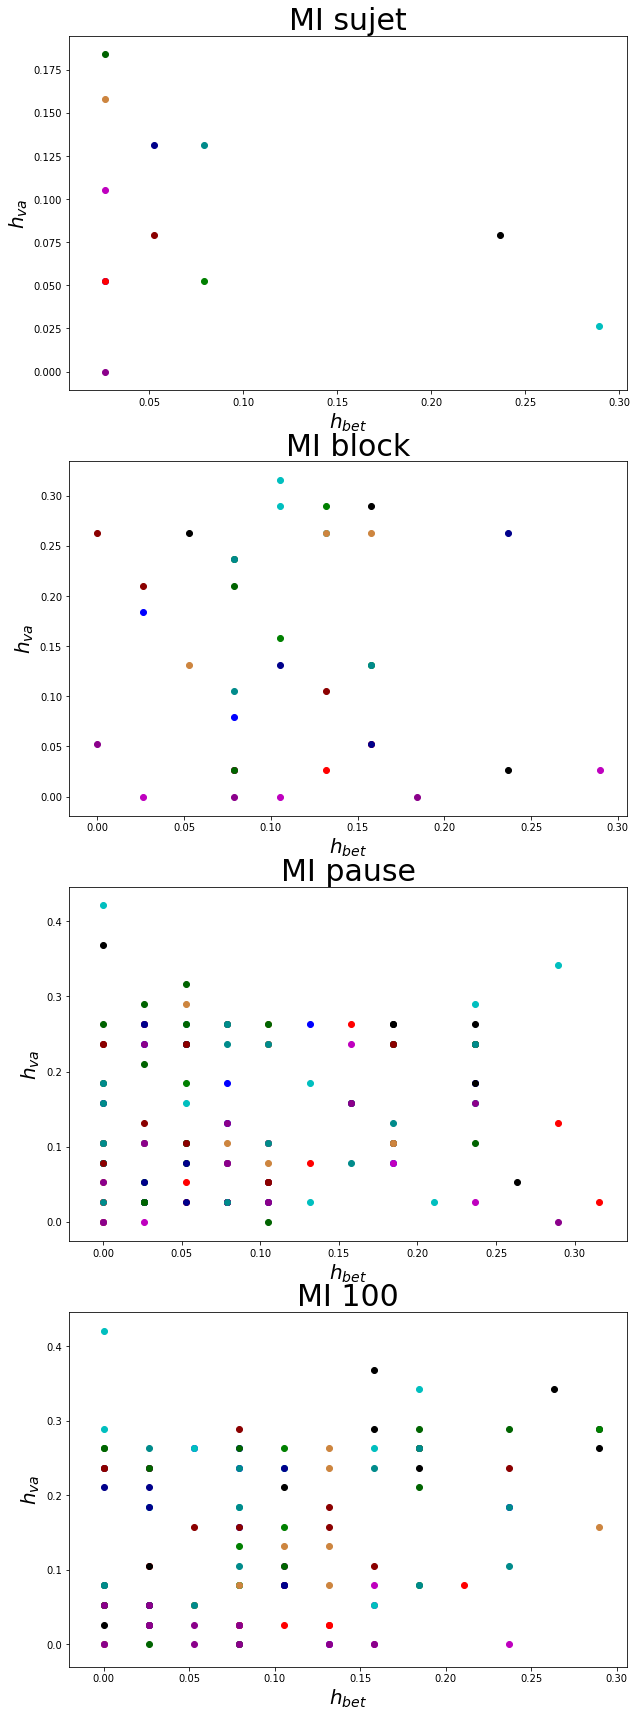

In [6]:
modes_bcp = 'mean'
list_h = np.linspace(0, 0.5, 20)

fig, ax = plt.subplots(4,1,figsize=(10,10*3))

COLOR = ['b', 'r', 'k', 'g', 'm', 'c',
         'darkblue', 'darkred', 'peru', 'darkgreen', 'darkmagenta', 'darkcyan']


for num, s in enumerate(set(Full.sujet)) :
    print(s, end=' ')
    va = Full['va'][Full.sujet==s].values.tolist()
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())
    
    mi_va_s, mi_bet_s = [], []
    mi_va_b, mi_bet_b = [], []
    mi_va_p, mi_bet_p = [], []
    mi_va_100, mi_bet_100 = [], []
    for b in range(3):
        mi_va_b.append([]) ; mi_bet_b.append([])
        mi_va_p.append([]) ; mi_bet_p.append([])
        mi_va_100.append([]) ; mi_bet_100.append([])
        liste = [0, 50, 100, 150, 200]
        for a in range(len(liste)-1) : mi_va_p[b].append([]) ; mi_bet_p[b].append([])
        liste = [0, 50, 100]
    
    for d, c in enumerate(range(0, 3*200-50, 50)) : mi_va_100.append([]) ; mi_bet_100.append([])
    
    h_va_b, h_bet_b = [], []
    h_va_p, h_bet_p = [], []
    h_va_100, h_bet_100 = [], []
    
    for h in list_h :
        p_hat_s = np.zeros(len(x))
        
        for b in range(3):
            nb = 200*b
            p_hat_b = np.zeros(200)
            
            liste = [0, 50, 100, 150, 200]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x[nb+liste[a]:nb+liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                
                p_hat_b[liste[a]:liste[a+1]] = p_hat_p
                p_hat_s[nb+liste[a]:nb+liste[a+1]] = p_hat_p

                mi_va_p[b][a].append(mutual_information(p_hat_p.tolist(),
                                                        va[nb+liste[a]:nb+liste[a+1]], bin_p=20, bin_data=2.5))
                mi_bet_p[b][a].append(mutual_information(p_hat_p.tolist(),
                                                         bet[nb+liste[a]:nb+liste[a+1]], bin_p=20, bin_data=2.5))
                  
            mi_va_b[b].append(mutual_information(p_hat_b.tolist(), va[nb:nb+200], bin_p=20, bin_data=10))
            mi_bet_b[b].append(mutual_information(p_hat_b.tolist(), bet[nb:nb+200], bin_p=20, bin_data=10))

            
        for d, c in enumerate(range(0, 3*200-50, 50)) :
            
            x_100 = x[c:c+100]
            p_hat_100 = np.zeros(100)
            
            liste = [0, 50, 100]
            for a in range(len(liste)-1) :
                p_bar, r_bar, beliefs = bcp.inference(x_100[liste[a]:liste[a+1]], h=h, p0=.5, r0=1.)
                p_hat_p, r_hat = bcp.readout(p_bar, r_bar, beliefs, mode=modes_bcp, p0=.5, fixed_window_size=40)
                p_hat_100[liste[a]:liste[a+1]] = p_hat_p
            
            mi_va_100[d].append(mutual_information(p_hat_100.tolist(), va[c:c+100], bin_p=20, bin_data=5))
            mi_bet_100[d].append(mutual_information(p_hat_100.tolist(), bet[c:c+100], bin_p=20, bin_data=5))

            
        mi_va_s.append(mutual_information(p_hat_s.tolist(), va, bin_p=20, bin_data=30))
        mi_bet_s.append(mutual_information(p_hat_s.tolist(), bet, bin_p=20, bin_data=30))
    
    for b in range(3):
        h_va_b.append(list_h[np.argmax(mi_va_b[b])])
        h_bet_b.append(list_h[np.argmax(mi_bet_b[b])])

        liste = [0, 50, 100, 150, 200]
        for a in range(len(liste)-1) :
            h_va_p.append(list_h[np.argmax(mi_va_p[b][a])])
            h_bet_p.append(list_h[np.argmax(mi_bet_p[b][a])])
            
    for d, c in enumerate(range(0, 3*200-50, 50)) :
        h_va_100.append(list_h[np.argmax(mi_va_100[d])])
        h_bet_100.append(list_h[np.argmax(mi_bet_100[d])])
    
        
    ax[0].scatter(list_h[np.argmax(mi_bet_s)], list_h[np.argmax(mi_va_s)], c=COLOR[num])
    ax[1].scatter(h_va_b, h_bet_b, c=COLOR[num])
    ax[2].scatter(h_va_p, h_bet_p, c=COLOR[num])
    ax[3].scatter(h_va_100, h_bet_100, c=COLOR[num])
     
for a, t in zip(ax, ['MI sujet', 'MI block', 'MI pause', 'MI 100']) :
    a.set_title(t, fontsize=30)
    a.set_xlabel('$h_{bet}$', fontsize=20)
    a.set_ylabel('$h_{va}$', fontsize=20) ;